In [187]:
using Pkg
if !haskey(Pkg.installed(), "Images") || !haskey(Pkg.installed(), "ImageMagick") || !haskey(Pkg.installed(), "FileIO") || !haskey(Pkg.installed(), "Glob")
    println("Installing required packages...")
    Pkg.add.(["Images", "ImageMagick", "FileIO", "Glob"])
end


using Plots
using LinearAlgebra
using GenericLinearAlgebra
using Images
using FileIO
using Glob
using ImageMagick  # pode ser necessário para JPEG


┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744


In [188]:
function complete_orthonormal(U::Matrix{Float64})
    d, r = size(U)
    r ≤ d || error("U deve ter no máximo d colunas")

    r == d && return zeros(Float64, d, 0)   # já completa

    # Projeta vetores aleatórios no complemento de span(U)
    Z = randn(Float64, d, d - r)
    Z .-= U * (U' * Z)                      # remove componente em U

    # QR fino garante ortonormalidade
    C = Matrix(qr(Z).Q)                  # d × (d−r)
    return C
end

complete_orthonormal (generic function with 1 method)

In [189]:
function build_csd_input_matrix(D1::Matrix{Float64}, D2::Matrix{Float64})
    # Dimensões
    m, d = size(D1)  # D1: m x d
    n, _ = size(D2)  # D2: n x d

    # Passo 1: QR de D1^T para obter base de R(D1) em R^d
    Q1 = Matrix(qr(D1').Q)  # Q1 é d x m
    R1 = Matrix(qr(D1').R)  # R1 é m x m

    println("Q1: ", size(Q1))  # Debugging: verificar tamanho de Q1
    println("R1: ", size(R1))  # Debugging: verificar tamanho de R1

    r1 = sum(abs.(diag(R1)) .> eps() * maximum(abs.(diag(R1))))  # Estimar posto
    E1 = Q1[:, 1:r1]  
    E2 = complete_orthonormal(E1)  # Base ortonormal completa para R^d, d x (d - r1)
    E = hcat(E1, E2)  # Base ortonormal completa para R^d, d x d
    
    # Passo 2: QR de D2^T para obter base de R(D2) em R^d
    Q2 = Matrix(qr(D2').Q)  # Q2 é d x n
    R2 = Matrix(qr(D2').R)  # R2 é n x n

    println("Q2: ", size(Q2))  # Debugging: verificar tamanho de Q2
    println("R2: ", size(R2))  # Debugging: verificar tamanho de R2

    c1 = sum(abs.(diag(R2)) .> eps() * maximum(abs.(diag(R2))))  # Estimar posto
    F1 = Q2[:, 1:c1]  
    F2 = complete_orthonormal(F1)  # Base ortonormal completa para R^d, d x (d - c1)
    

    # Passo 3: Calcular Q11 = E1^T F1
    Q11 = E1' * F1  # r1 x c1
    Q12 = E1' * F2  # r1 x (d - c1)
    Q21 = E2' * F1  # (d - r1) x c1
    Q22 = E2' * F2  # (d - r1) x (d - c1)

    # Passo 4: Concatenar Q11, Q12, Q21, Q22
    Qtop = hcat(Q11, Q12)
    Qbot = hcat(Q21, Q22)
    Q = vcat(Qtop, Qbot)
    
    return Q, r1, c1, E, E1, F1, R1, R2
end

build_csd_input_matrix (generic function with 1 method)

In [190]:
function rebuild_datasets_matrices(E, R)
    D_reconstructed = R' * E'  
    # Retornar a matriz reconstruída
    return D_reconstructed
end

rebuild_datasets_matrices (generic function with 1 method)

In [191]:
function verify_Q(Q::Matrix{Float64})
    if Q'*Q ≈ I
        println("A matriz Q é ortonormal")
    else
        println("A matriz Q não é ortonormal")
        
    end
end

verify_Q (generic function with 1 method)

In [192]:
function load_images_as_dataset(folder_path::String)
    # Lista todos os arquivos JPEG na pasta
    image_paths = Glob.glob("*.jpg", folder_path)
    num_images = min(length(image_paths), 100)  # Limita para no máximo 100 imagens

    if num_images == 0
        error("Nenhuma imagem encontrada na pasta.")
    end

    # Carrega uma imagem para obter dimensões
    img_sample = load(image_paths[1])
    img_gray = convert(Array{Gray{N0f8}}, img_sample)
    h, w = size(img_gray)

    println("Dimensões da imagem: $h x $w")

    # Inicializa matriz dataset
    dataset = zeros(Float64, num_images, h * w)

    for (i, path) in enumerate(image_paths[1:num_images])
        img = load(path)
        img_gray = convert(Array{Gray{N0f8}}, img)  # Converte para escala de cinza
        dataset[i, :] = vec(img_gray)  # Converte a imagem para vetor e armazena
    end

    return dataset, h, w
end



load_images_as_dataset (generic function with 1 method)

In [193]:
function reconstruct_image_from_vector(X::Matrix{Float64}, h::Int, w::Int, img_num::Int)
    vec_img = X[img_num, :]
    img_gray = reshape(vec_img, h, w)  # Reshape para a imagem em escala de cinza
    
    return img_gray
end


reconstruct_image_from_vector (generic function with 1 method)

In [194]:
#"D:\Docs matheus\UFRJ\7-Setimo Periodo\Alg. Lininear Aplicada\Trabalho final\Dataset PlayingCards\train\(card name)"

folder1 = raw"D:\Docs matheus\UFRJ\7-Setimo Periodo\Alg. Lininear Aplicada\Trabalho final\MNIST\trainingSet\trainingSet\0"
X, h, w = load_images_as_dataset(folder1)
size(X) 

Dimensões da imagem: 28 x 28


(100, 784)

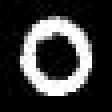

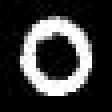

In [195]:
num = 1  # Número da imagem que você quer reconstruir
#se o folder contém "train", usa o formato com zeros à esquerda
#se não (se for "test"), usa o formato sem zeros à esquerda
img_path = (folder1 * "\\img_" * string(num) * ".jpg") 
img9 = load(img_path)
display(img9)
num = 1
img9_reconstruct= reconstruct_image_from_vector(X, h, w, num)
display(colorview(Gray, img9_reconstruct))

In [196]:
function display_image_grid(X::Matrix{Float64}, img_size::Tuple{Int,Int}, indices::Vector{Int}; grid_shape::Tuple{Int,Int}=nothing)
    n_imgs = length(indices)
    h, w = img_size

    # Define grid shape if not provided
    if grid_shape === nothing
        ncols = ceil(Int, sqrt(n_imgs))
        nrows = ceil(Int, n_imgs / ncols)
    else
        nrows, ncols = grid_shape
    end

    # Create empty canvas for each channel
    grid = zeros(Float64, nrows*h, ncols*w)

    n_pixels = h * w

    for (k, idx) in enumerate(indices)
        row = div(k-1, ncols)
        col = mod(k-1, ncols)
        img_gray =reconstruct_image_from_vector(X, h, w, idx)
        grid[(row*h+1):(row+1)*h, (col*w+1):(col+1)*w] .= img_gray

    end

    return (colorview(Gray, grid))
end


display_image_grid (generic function with 1 method)

In [197]:
function best_grid_shape(n_imgs::Int)
    # Procura divisores de n_imgs para formar um grid mais "quadrado" possível
    best_rows, best_cols = 1, n_imgs
    min_diff = n_imgs
    for rows in 1:floor(Int, sqrt(n_imgs))
        if n_imgs % rows == 0
            cols = div(n_imgs, rows)
            if abs(rows - cols) < min_diff
                best_rows, best_cols = rows, cols
                min_diff = abs(rows - cols)
            end
        end
    end
    # Se n_imgs é primo, usa aproximação quadrada
    if (best_rows == 1 || abs(best_rows - best_cols) > min(best_rows, best_cols)) && n_imgs > 10
        best_rows = floor(Int, sqrt(n_imgs))
        best_cols = ceil(Int, n_imgs / best_rows)
    end
    return best_rows, best_cols
end


best_grid_shape (generic function with 1 method)

Número de imagens no dataset: 100
Número de linhas do grid: 10
Número de colunas do grid: 10


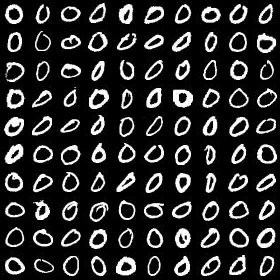

In [198]:
size_dataset = size(X, 1)
grid_rows, grid_cols = best_grid_shape(size_dataset)
println("Número de imagens no dataset: ", size_dataset)
println("Número de linhas do grid: ", grid_rows)
println("Número de colunas do grid: ", grid_cols)
display_image_grid(X, (h, w), collect(1:size_dataset); grid_shape=(grid_rows, grid_cols))

In [199]:
folder2 = raw"D:\Docs matheus\UFRJ\7-Setimo Periodo\Alg. Lininear Aplicada\Trabalho final\MNIST\trainingSet\trainingSet\7"
Y, h, w = load_images_as_dataset(folder2)
size(Y) 

Dimensões da imagem: 28 x 28


(100, 784)

Número de imagens no dataset: 100
Número de linhas do grid: 10
Número de colunas do grid: 10


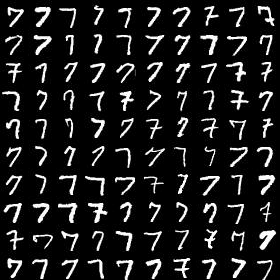

In [200]:

size_dataset = size(Y, 1)
grid_rows, grid_cols = best_grid_shape(size_dataset)
println("Número de imagens no dataset: ", size_dataset)
println("Número de linhas do grid: ", grid_rows)
println("Número de colunas do grid: ", grid_cols)
display_image_grid(Y, (h, w), collect(1:size_dataset); grid_shape=(grid_rows, grid_cols))

In [201]:
println("Tamanho do dataset X: ", size(X))
println("Tamanho do dataset Y: ", size(Y))
println("tamanho da imagem: ", h, " x ", w)


Tamanho do dataset X: (100, 784)
Tamanho do dataset Y: (100, 784)
tamanho da imagem: 28 x 28


In [202]:
# Exemplo de uso da função build_csd_input_matrix
Q, r1, c1, E, E1, F1, R1, R2 = build_csd_input_matrix(X, Y)

Q1: (784, 100)
R1: (100, 100)
Q2: (784, 100)
R2: (100, 100)


([0.4613564707065417 0.24263480658230938 … 0.01587939301467414 -0.020889981174658876; 0.2602496308454134 0.038301545819284834 … 0.007131430481983607 -0.008388075061381875; … ; 0.020191782440895197 -0.007190787429573938 … 0.04892603373941338 -0.013536287307711357; -0.004387501614402813 0.0037976954332205573 … 0.02338907704935816 -0.026235759099109086], 100, 100, [-0.0009449456342940366 0.0008377619082988937 … -0.01606684990385639 -0.02838501247165098; 0.0 0.0 … 0.027970403274773466 0.07050034118933746; … ; 0.0 0.0 … 0.02782803062584446 0.0182941212528492; 0.0 0.0 … 0.023949876808001938 0.013698172979791], [-0.0009449456342940366 0.0008377619082988937 … 0.001454327122924711 -0.001353720919337563; 0.0 0.0 … -0.0008883581872572631 5.828417637647454e-5; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 1.717376241217039e-16 … 0.007603751384016034 -0.0009264354911417863; 0.0 0.0 … 0.005745488759910993 0.0038751815299404146; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-12.450140468813794 -6.166

In [203]:
println(size(Q))  # Verifica o tamanho da matriz Q
println("Posto de D1: ", r1)
println("Posto de D2: ", c1)
println("Tamanho de E1: ", size(E1))  # Verifica o tamanho de E1
println("Tamanho de F1: ", size(F1))  # Verifica o tamanho de E2
println("Tamanho de R1: ", size(R1))  # Verifica o tamanho de R1
println("Tamanho de R2: ", size(R2))  # Verifica o tamanho de R2

(784, 784)
Posto de D1: 100
Posto de D2: 100
Tamanho de E1: (784, 100)
Tamanho de F1: (784, 100)
Tamanho de R1: (100, 100)
Tamanho de R2: (100, 100)


In [204]:
# Exibir e verificar a corretude da matriz A
verify_Q(Q)
X_reconstructed = rebuild_datasets_matrices(E1, R1)
Y_reconstructed = rebuild_datasets_matrices(F1, R2)

if X_reconstructed ≈ X && Y_reconstructed ≈ Y
    println("As matrizes reconstruídas são equivalentes às originais!")
else
    println("As matrizes reconstruídas NÃO são equivalentes às originais.")
        
end

A matriz Q é ortonormal
As matrizes reconstruídas são equivalentes às originais!


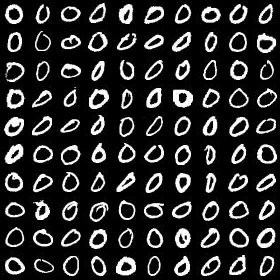

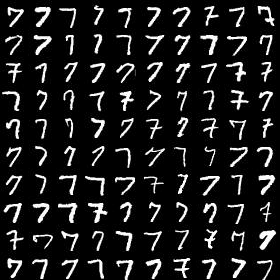

In [205]:
display(display_image_grid(X_reconstructed, (h, w), collect(1:size(X_reconstructed, 1)); grid_shape=(grid_rows, grid_cols)))
display(display_image_grid(Y_reconstructed, (h, w), collect(1:size(Y_reconstructed, 1)); grid_shape=(grid_rows, grid_cols)))

In [206]:
function csd(Q, c1, r1, E)
    d= size(Q, 1)  # Dimensão do espaço
    # separar Q em blocos
    Q11 = Q[1:r1, 1:c1]  # r1 x c1
    Q12 = Q[1:r1, c1+1:end]  # r1 x (d - c1)
    Q21 = Q[r1+1:end, 1:c1]  # ( d - r1) x c1
    Q22 = Q[r1+1:end, c1+1:end]  # (d - r1) x (d - c1)

    # SVD dos blocos de Q = EᵀF
    U1, S11, V1 = svd(Q11; full=true)     
    U2, S22, V2  = svd(Q22; full=true)

    D11 = U1' * Q11 * V1
    D12 = U1' * Q12 * V2 
    D21 = U2' * Q21 * V1
    D22 = U2' * Q22 * V2
    
    # Monta matriz diagonalizada D via blocos projetados
    D_top = hcat(D11, D12)  # r1 x d
    D_bot = hcat(D21, D22)  # (d - r1) x (d - c1)
    D = vcat(D_top, D_bot)  # d × d

    # Constrói matriz U unificada
    U = Matrix{Float64}(I, d, d)
    U[1:r1, 1:r1] = U1
    U[r1+1:end, r1+1:end] = U2
    
    # Constrói matriz V unificada
    V= Matrix{Float64}(I, d, d)
    V[1:c1, 1:c1] = V1
    V[c1+1:end, c1+1:end] = V2
    
    # Calcula os ângulos θ entre os subespaços
    θ = acos.(clamp.(S11, -1.0, 1.0))

    # Reconstrói a rotação W que leva E1 → F1
    W = E * U * D * U' * E'


    return U, U1, U2, V, V1, V2, D, θ, W  
end

csd (generic function with 1 method)

In [207]:
U, U1, U2, V, V1, V2, D, θ, W =csd(Q, c1, r1, E)

([0.6124026070035147 0.20485734068350459 … 0.0 0.0; 0.27065510047275954 -0.5493152921584689 … 0.0 0.0; … ; 0.0 0.0 … -0.030753741904414912 -0.08376986833728668; 0.0 0.0 … -0.002876753768113152 0.05525160665259708], [0.6124026070035147 0.20485734068350459 … 0.03336390397977677 0.06578246038948729; 0.27065510047275954 -0.5493152921584689 … 0.01016690779661077 -0.004883687450938144; … ; 0.0246303294272063 -0.003402221508930906 … -0.144491262042006 0.049720909647276594; -0.02030594724476028 -0.013937494261501204 … -0.08730705722221417 -0.11235724575112219], [0.04420353662816506 -0.020997260008827335 … 0.015323984276677086 -0.01894777730988307; 0.05000791288283745 -0.0003709521556488414 … -0.03758904980467338 -0.03639429858818052; … ; 0.03372850015836238 -0.01880511660991851 … -0.030753741904414912 -0.08376986833728668; -0.053411237905881426 -0.04480154280185814 … -0.002876753768113152 0.05525160665259708], [0.7033990298788838 -0.07436062945488214 … 0.0 0.0; 0.4530298368724082 0.16419692595

In [208]:
display(θ)                 # Ângulos principais entre subespaços (em radianos)
@show(U*D*V' ≈ Q) 
display(norm(W-I) ≈ norm(D-I))  # Deve ser próximo de 0 (rotação direta correta)
@show W*E1*U1*V1' ≈ F1 

100-element Vector{Float64}:
 0.14668317758430507
 0.23798951412465996
 0.2641210594659043
 0.2889255991210359
 0.3162668114418971
 0.33048152200985625
 0.35940225270776466
 0.37685955565721435
 0.3925811369606782
 0.40803116894262303
 ⋮
 1.5065945499593378
 1.516776321405853
 1.5206573459690698
 1.5224159351310207
 1.540864616243421
 1.5430817550651825
 1.5517164150989011
 1.5569565694648824
 1.5647626622035362

true

U * D * V' ≈ Q = true
W * E1 * U1 * V1' ≈ F1 = true


true

In [209]:
Y_reconstructed_from_rotation = rebuild_datasets_matrices(W*E1*U1*V1', R2)

if  Y_reconstructed_from_rotation ≈ Y
    println("A matriz Y reconstruída a partir da rotação de X é equivalente à original! :D")
else
    println("A matriz Y reconstruída a partir da rotação de X NÃO é equivalente à original. T-T")
end

A matriz Y reconstruída a partir da rotação de X é equivalente à original! :D


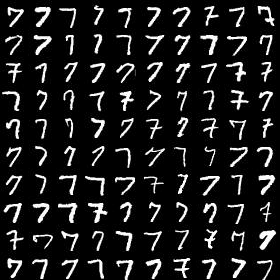

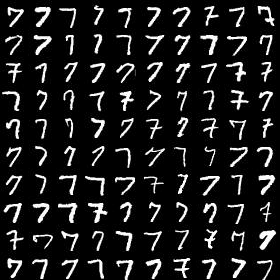

In [210]:
display(display_image_grid(Y_reconstructed_from_rotation, (h, w), collect(1:size(Y_reconstructed_from_rotation, 1)); grid_shape=(grid_rows, grid_cols)))
display(display_image_grid(Y, (h, w), collect(1:size(Y, 1)); grid_shape=(grid_rows, grid_cols)))

In [211]:
function smooth_transition(Q, c1, r1, E, R2, n_frames)
    U, U1, U2, V, V1, V2, D, θ, W =csd(Q, c1, r1, E)
    frames = []
    max_angle= Diagonal(θ)
    d=size(D, 1)  # Dimensão do espaço
    I_d = Matrix{Float64}(I, d, d)
    I_u = Matrix{Float64}(I, r1, r1)
    I_v = Matrix{Float64}(I, c1, c1)

    for mask in range(0, 1, length=n_frames)       
        Dm = mask * D + (1- mask )*I_d  # Aplicando máscara de ângulos
        Um = mask * U1 + (1- mask )*I_u  # Aplicando máscara de U
        Vm = mask * V1 + (1- mask )*I_v  # Aplicando máscara de V
        W = E * U * Dm * U' * E'
        Y_reconstructed_from_rotation = rebuild_datasets_matrices(W*E1*Um*Vm', R2)
        img = display_image_grid(Y_reconstructed_from_rotation, (h, w), collect(1:size(Y_reconstructed_from_rotation, 1)); grid_shape=(grid_rows, grid_cols))
        frame = clamp.(img,0,1)
        push!(frames, frame)
    end
    save("CSD_rotation.gif", cat(frames..., dims=3))
end

smooth_transition (generic function with 2 methods)

In [212]:
smooth_transition(Q, c1, r1, E, R2, 30)